# Medical Image Registration Using Voxelmorph
## Intelligent Analysis of Biomedical Images - Fall 2022
## Instructor: Dr. M. H. Rohban
## HW5 - Practical
## Student Name: Ghazal Farahani
## Student ID: 98104358


In this assignment, you are going to train a voxelmorph network to do the unsupervised image registration task. You are going to use the [CHAOS MR T2 dataset](https://chaos.grand-challenge.org/), which is available to you from this google drive folder: [dataset](https://drive.google.com/drive/folders/1BGPa--fsmf8I5AeyFxa142N4lXpTqzIG?usp=sharing).
In this folder, you have access to 20 3D MR images of 20 different patients. Each image has its own number of slices (2D images) and consists of only one channel (gray-scaled images).

In the folder provided, you will have four different types of objects:


1.   the image itself
2.   the foreground mask (fgmask) of the image
3.   the label of the image
4.   the superpixels of the image

You have nothing to do with the superpixels; they are just in the folder. 

### Trianing
In the following sections, you may read the data, get familiar with it, and implement a Pytorch code that trains a Voxelmorph network to register a moving image (2D) to a fixed image (also 2D). 

1.   Do your training with 19 images (all except the last one which has the ID 39; we need it for the testing part)
2.   You have to train your network in an unsupervised manner (don't use labels in training)
3.   Use voxelmorph library; you don't need to implement the model yourself
4.   Use both similarity and smoothness losses. You may use trial and error to determine the best combination of these losses.
5. Plot the training loss  
6. Visualize your model's ability to register images by plotting at least 10 (moving, moved, fixed) triplets
6.   You may use creative approaches to improve your results (e.g., train bidirectional, train with not adjacent slices, etc.)

### Testing


1.   Pick the patient 39 image and label
2.   Find the range of slices in which all slices have a labeled organ (slices whose label is not blank)
3.   Pick the middle slice in the range mentioned above
4.   Propagate its label to the whole volume using your trained model (using the displacement fields)
5.   Visualize your results. Plot propagated labels and actual labels in order to do an intuitive comparison
6.   Take the dice score between the propagated labels and the actual labels of slices. Report them one by one. Take the average of those. Report this number as the final metric of evaluation of your model.







In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install voxelmorph 
!pip install SimpleITK -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.3 MB/s eta 0:00:00


In [3]:
import os, sys
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.')
import voxelmorph as vxm
import neurite as ne
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import torch
import SimpleITK as sitk
import pickle
import json
import time
import random 
import scipy

In [4]:
class Patient:
    def __init__(self, id_):
        self.id = id_
        self.frames_count = None
        self.fgmasks = None
        self.images = None
        self.labels = None

    def remove_without_labels(self):
        idx = []
        for frame_number, label in enumerate(self.labels):
            if label.max() > 0:
                idx.append(frame_number)
        self.frames_count = len(idx)
        self.fgmasks = self.fgmasks[idx]
        self.images = self.images[idx]
        self.labels = self.labels[idx]
        
    def print_data_shapes(self):
        print('patient ', self.id)
        print('fmgasks: ', self.fgmasks.shape)
        print('images: ', self.images.shape)
        print('lables: ', self.labels.shape)
        print('-' * 30)

    def plot(self, frame_number):
        fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(self.images[frame_number], origin='lower', cmap='gray')
        ax2.imshow(self.fgmasks[frame_number], origin='lower', cmap='gray')
        ax3.imshow(self.labels[frame_number], origin='lower', cmap='gray')
        ax1.set_title("image")
        ax2.set_title("fgmask")
        ax3.set_title("lable")


def create_patients(ids):
    patients = {}
    for id_ in ids:
        patients[id_] = Patient(id_)
    return patients


In [5]:
def save_patients_images(path):
    images = {}
    for id, patient in patients.items():
        images[id] = patient.images
    with open(path, 'wb') as f:
        pickle.dump(images, f)


def save_patients_superpixs(path):
    superpixs = {}
    for id, patient in patients.items():
        superpixs[id] = patient.superpixs
    with open(path, 'wb') as f:
        pickle.dump(superpixs, f)


def save_patients_labels(path):
    labels = {}
    for id, patient in patients.items():
        labels[id] = patient.labels
    with open(path, 'wb') as f:
        pickle.dump(labels, f)


def read_nii_bysitk(input_fid, peel_info=False):
    """ read nii to numpy through simpleitk
        peelinfo: taking direction, origin, spacing and metadata out
    """
    img_obj = sitk.ReadImage(input_fid)
    img_np = sitk.GetArrayFromImage(img_obj)
    if peel_info:
        info_obj = {
            "spacing": img_obj.GetSpacing(),
            "origin": img_obj.GetOrigin(),
            "direction": img_obj.GetDirection(),
            "array_size": img_np.shape
        }
        return img_np, info_obj
    else:
        return img_np

In [31]:
patient_ids = [1, 2, 3, 5, 8, 10, 13, 15, 19, 20, 21, 22, 31, 32, 33, 34, 36, 37, 38, 39]
project_root = "/content/gdrive/MyDrive/"
data_root = '/content/gdrive/MyDrive/chaos_MR_T2_normalized/'

patients = create_patients(patient_ids)
for path in tqdm(glob.iglob(data_root + '**/*.nii.gz', recursive=True), desc="Reading"):
    id_ = int(path.split('_')[-1].split('.')[0])
    patient = patients.get(id_)
    obj = read_nii_bysitk(path)
    if 'fgmask' in path:
        patient.fgmasks = obj
        patient.frames_count = obj.shape[0]
    elif 'image' in path:
        patient.images = obj
    elif 'label' in path:
        patient.labels = obj

Reading: 80it [00:04, 17.88it/s]


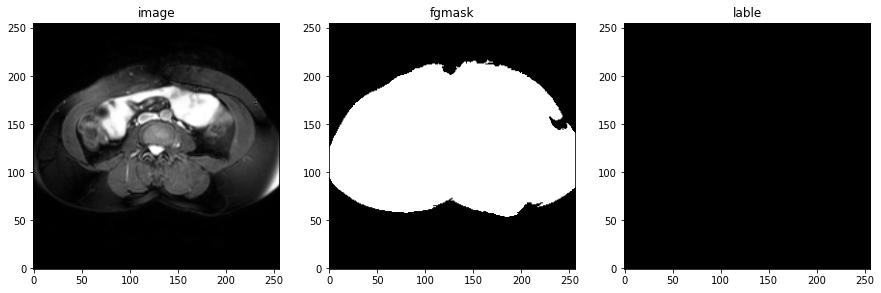

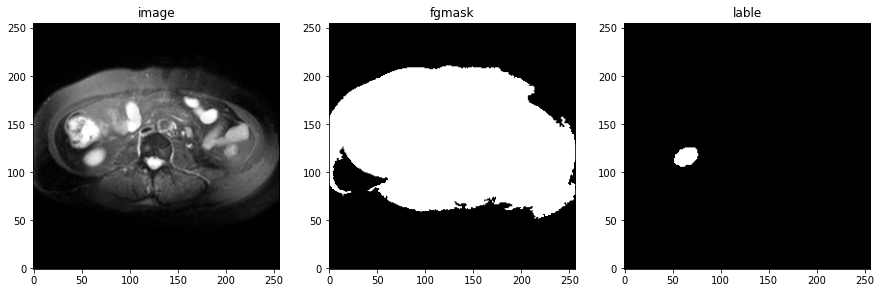

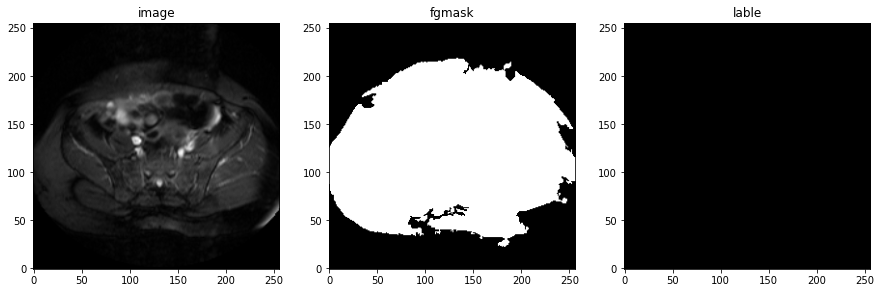

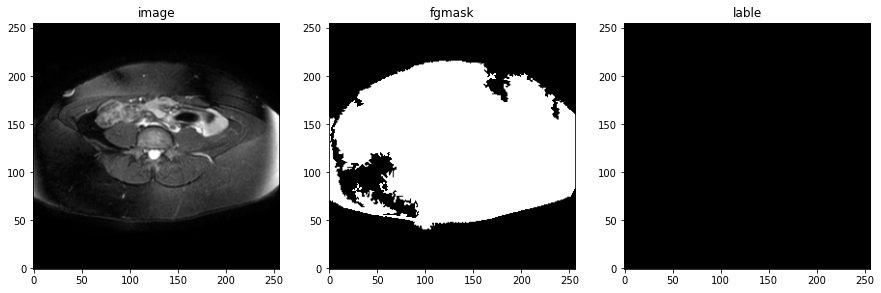

In [7]:
for i in random.sample(patient_ids, 4):
  patients[i].plot(1)

In [32]:
ndim = 2
unet_input_features = 2
inshape = patients[1].images[1].shape

nb_features = [
    [32, 32, 32, 32],
    [32, 32, 32, 32, 32, 16]
]

vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [9]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 256, 256, 1), (None, 256, 256, 1)
output shape: (None, 256, 256, 1), (None, 256, 256, 2)


In [33]:
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [34]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [35]:
train_ids = patient_ids[: -1]
x_train = []

for i in train_ids:
  x_train.extend([patients[i].images[j] for j in range(patients[i].images.shape[0])])

x_train = np.array(x_train)
print("train shape:", x_train.shape)

train shape: (687, 256, 256)


In [36]:
x_train = x_train.astype('float')/255

In [37]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [38]:
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

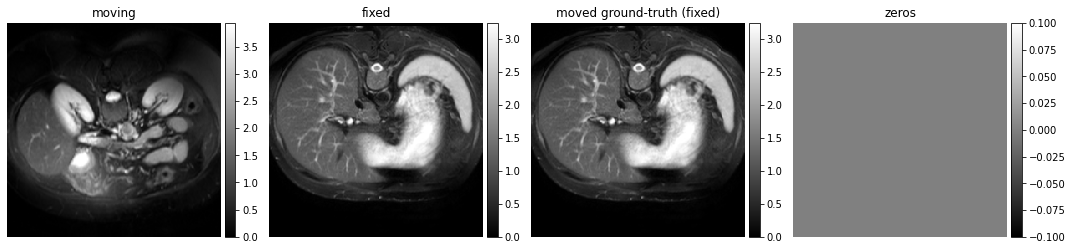

(<Figure size 1080x270 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e50f757c0>,
       dtype=object))

In [39]:
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [40]:
nb_epochs = 100
steps_per_epoch = 100
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)

Epoch 1/100
100/100 - 13s - loss: 0.4379 - vxm_dense_transformer_loss: 0.4244 - vxm_dense_flow_loss: 0.2712 - 13s/epoch - 129ms/step
Epoch 2/100
100/100 - 8s - loss: 0.3505 - vxm_dense_transformer_loss: 0.3296 - vxm_dense_flow_loss: 0.4178 - 8s/epoch - 82ms/step
Epoch 3/100
100/100 - 8s - loss: 0.3216 - vxm_dense_transformer_loss: 0.2985 - vxm_dense_flow_loss: 0.4612 - 8s/epoch - 83ms/step
Epoch 4/100
100/100 - 8s - loss: 0.3114 - vxm_dense_transformer_loss: 0.2873 - vxm_dense_flow_loss: 0.4827 - 8s/epoch - 77ms/step
Epoch 5/100
100/100 - 8s - loss: 0.2957 - vxm_dense_transformer_loss: 0.2718 - vxm_dense_flow_loss: 0.4790 - 8s/epoch - 83ms/step
Epoch 6/100
100/100 - 8s - loss: 0.2961 - vxm_dense_transformer_loss: 0.2720 - vxm_dense_flow_loss: 0.4820 - 8s/epoch - 78ms/step
Epoch 7/100
100/100 - 8s - loss: 0.2749 - vxm_dense_transformer_loss: 0.2485 - vxm_dense_flow_loss: 0.5275 - 8s/epoch - 79ms/step
Epoch 8/100
100/100 - 8s - loss: 0.2781 - vxm_dense_transformer_loss: 0.2514 - vxm_dens

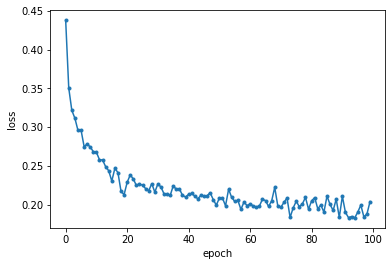

In [41]:
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [42]:
patients[patient_ids[-1]].remove_without_labels()
number_of_images = len(patients[patient_ids[-1]].images)
middle = number_of_images // 2
middle_label = patients[patient_ids[-1]].labels[middle]

In [22]:
def dice_score(im1, im2):
  im1 = np.asarray(im1).astype(bool)
  im2 = np.asarray(im2).astype(bool)
  intersection = np.logical_and(im1, im2)
  score = 2. * intersection.sum() / (im1.sum() + im2.sum())
  return score

1/1 [==============================] - 0s 22ms/step


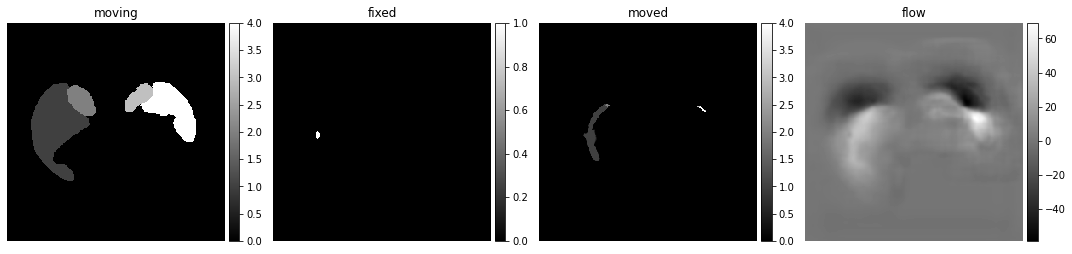

1/1 [==============================] - 0s 23ms/step


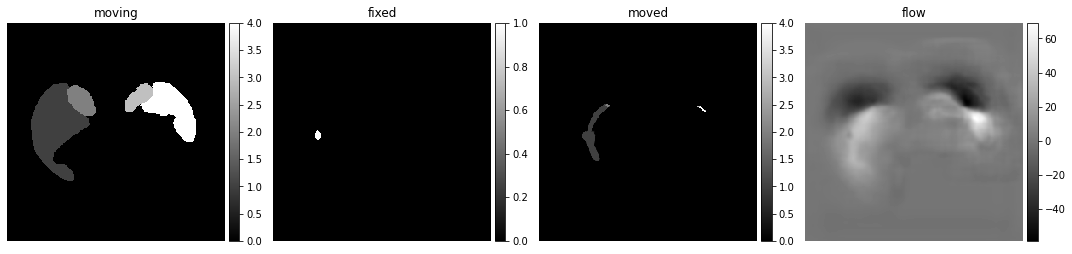

1/1 [==============================] - 0s 22ms/step


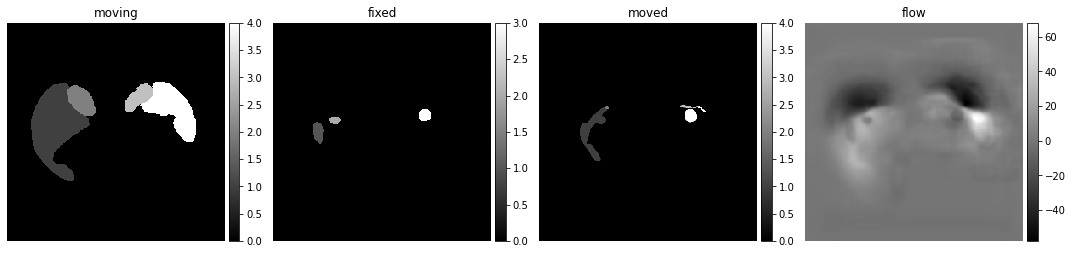

1/1 [==============================] - 0s 25ms/step


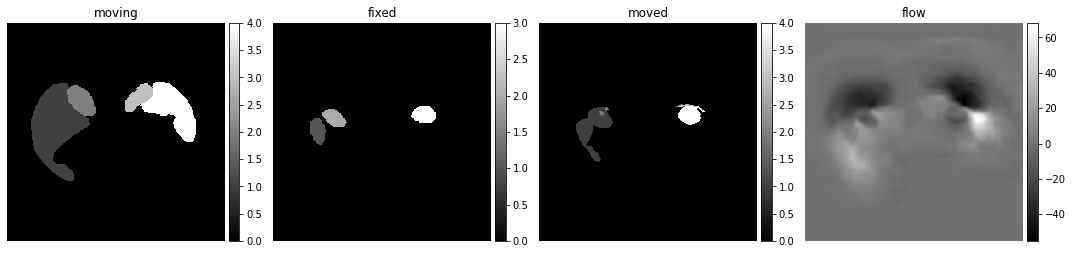

1/1 [==============================] - 0s 23ms/step


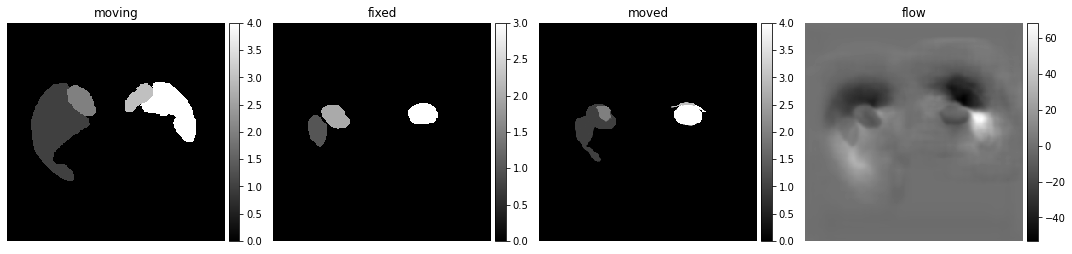

1/1 [==============================] - 0s 38ms/step


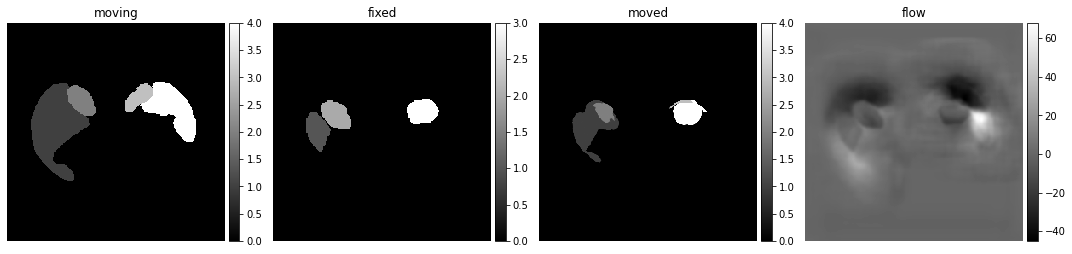

1/1 [==============================] - 0s 33ms/step


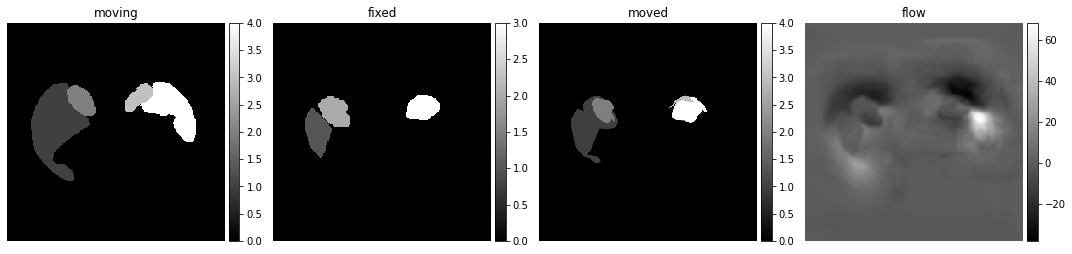

1/1 [==============================] - 0s 28ms/step


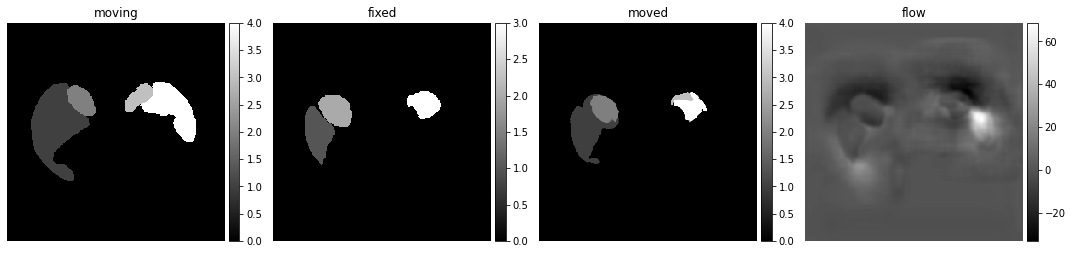

1/1 [==============================] - 0s 28ms/step


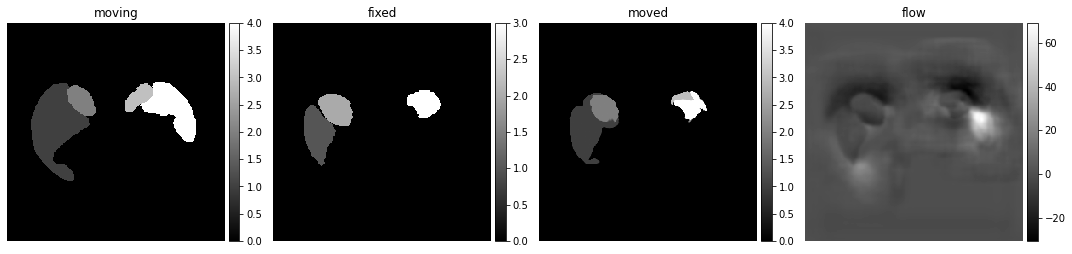

1/1 [==============================] - 0s 30ms/step


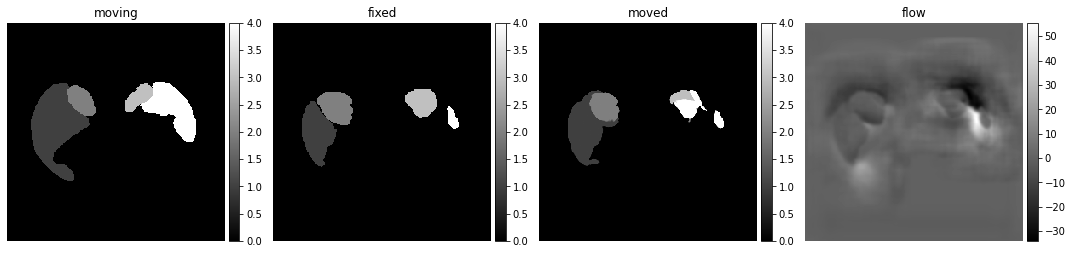

1/1 [==============================] - 0s 23ms/step


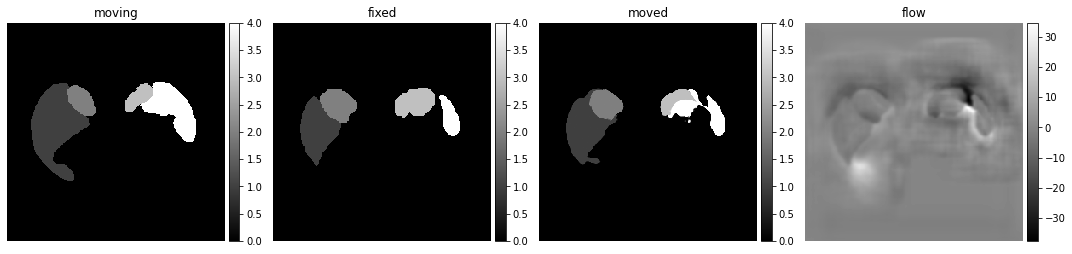

1/1 [==============================] - 0s 27ms/step


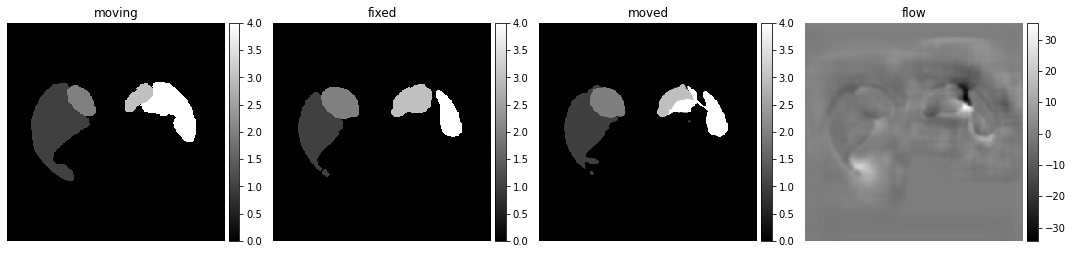

1/1 [==============================] - 0s 23ms/step


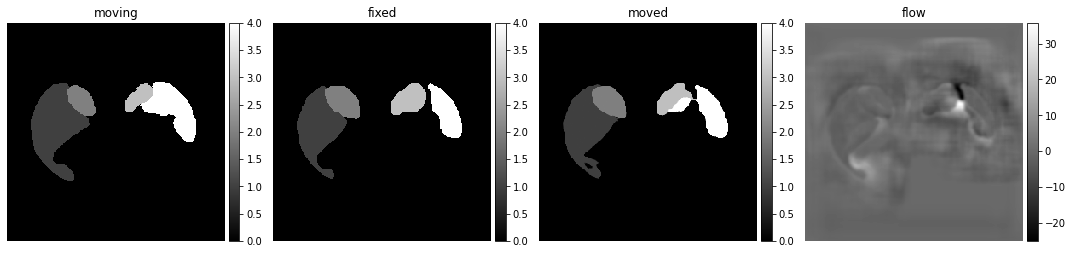

1/1 [==============================] - 0s 23ms/step


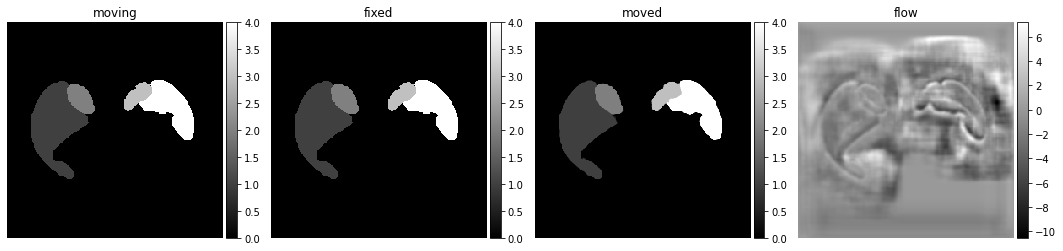

1/1 [==============================] - 0s 19ms/step


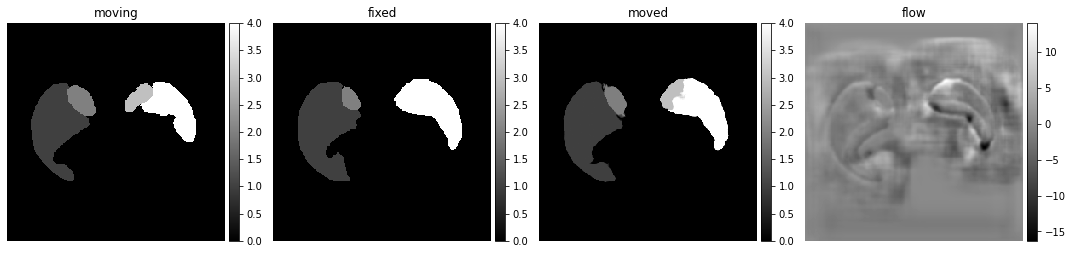

1/1 [==============================] - 0s 20ms/step


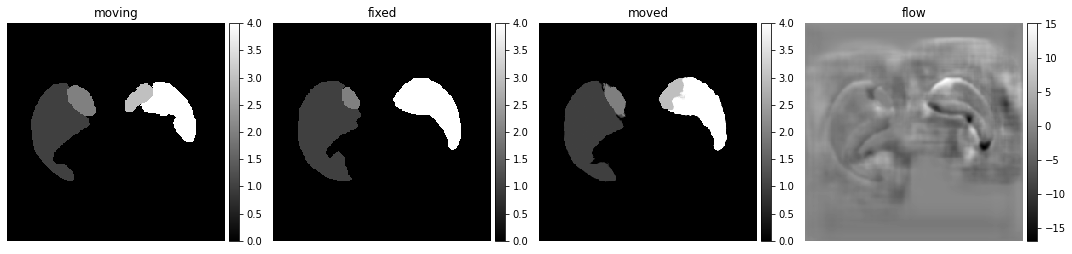

1/1 [==============================] - 0s 21ms/step


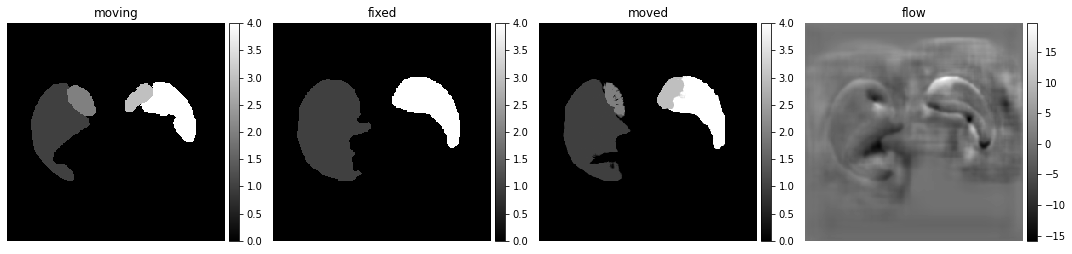

1/1 [==============================] - 0s 22ms/step


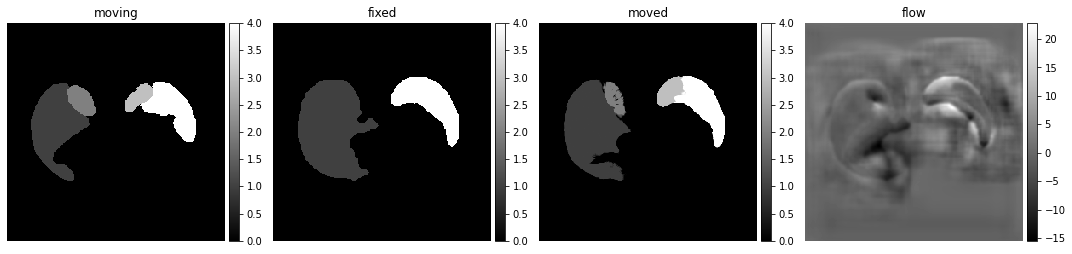

1/1 [==============================] - 0s 21ms/step


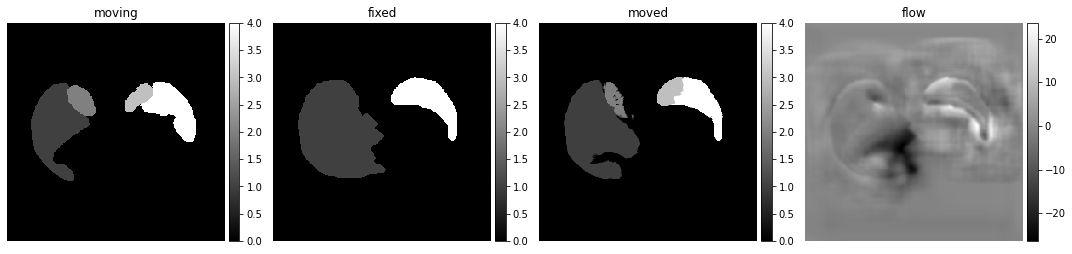

1/1 [==============================] - 0s 28ms/step


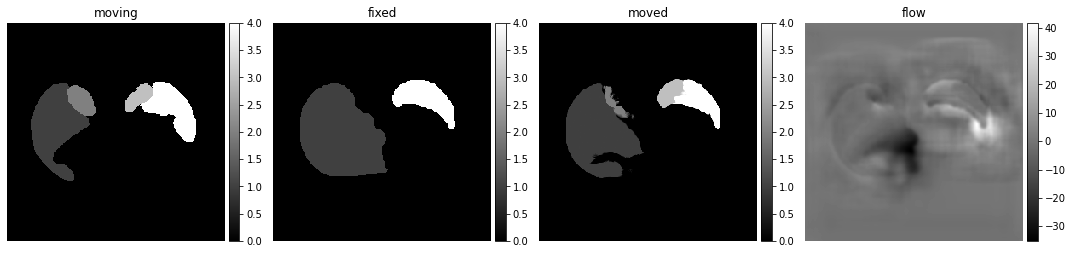

1/1 [==============================] - 0s 20ms/step


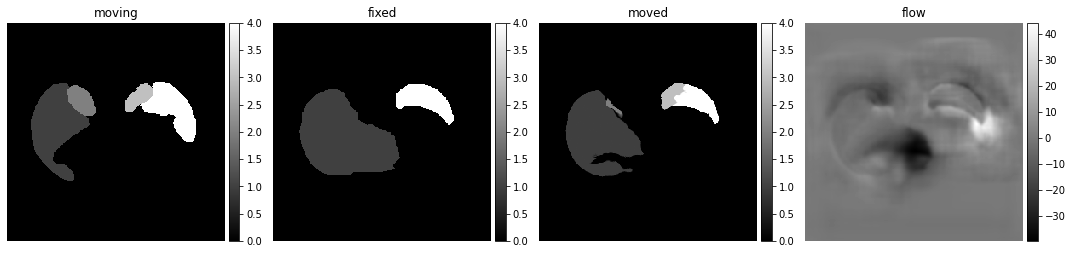

1/1 [==============================] - 0s 21ms/step


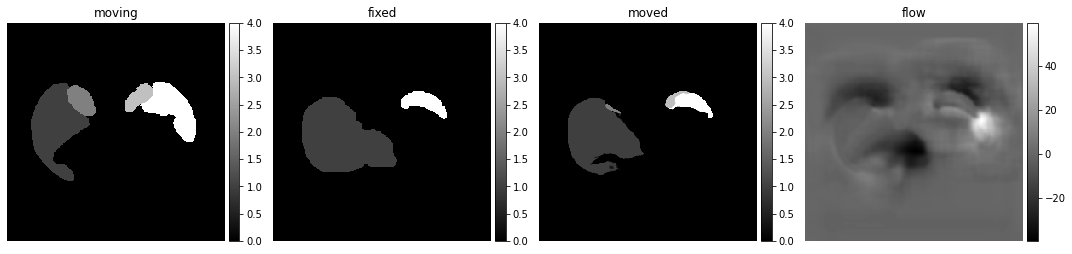

1/1 [==============================] - 0s 20ms/step


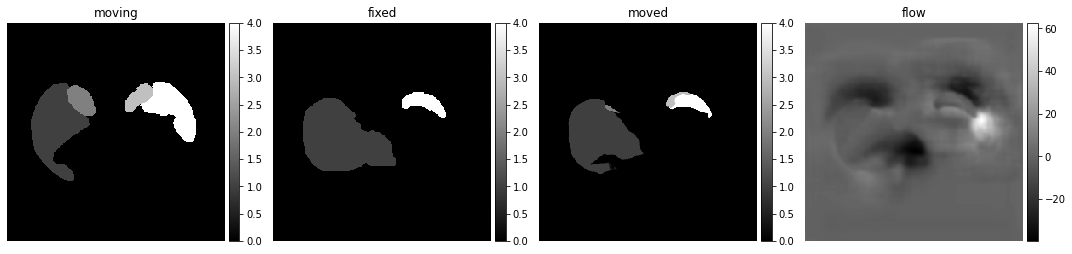

1/1 [==============================] - 0s 20ms/step


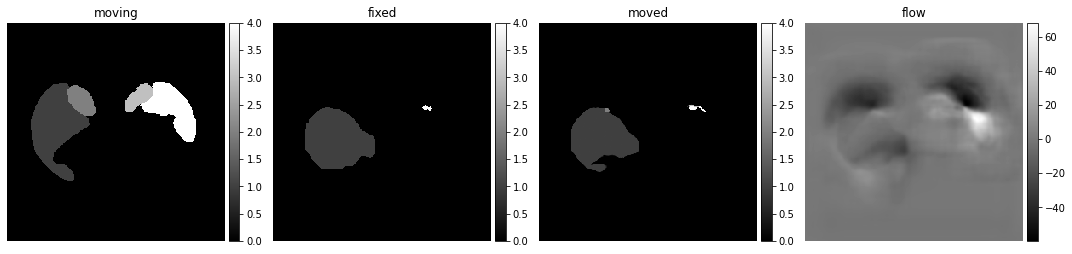

1/1 [==============================] - 0s 19ms/step


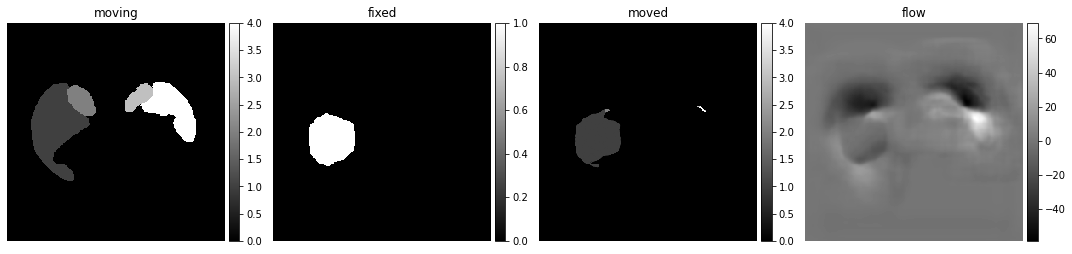

1/1 [==============================] - 0s 28ms/step


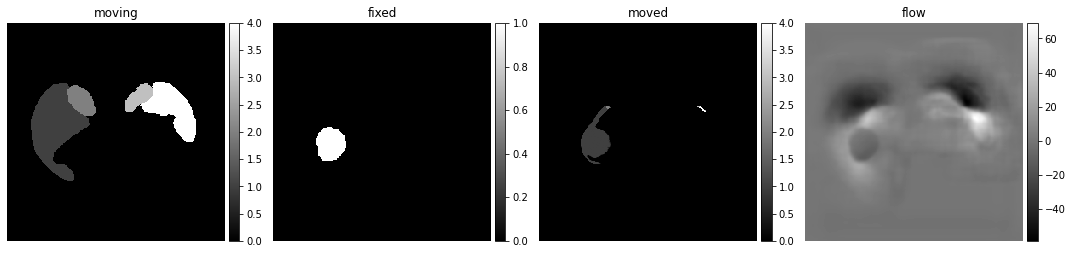

In [ ]:
scores = []
flows = []

vxn_model = vxm.networks.Transform((256, 256, 1), interp_method='nearest')

for i in range(number_of_images):
  test_pred = vxm_model.predict([middle_label[np.newaxis, ..., np.newaxis], 
                                 patients[patient_ids[-1]].labels[i][np.newaxis, ..., np.newaxis]])
  score = dice_score(test_pred[0][0, :, :, 0], patients[patient_ids[-1]].labels[i])
  scores.append(score)
  flow = test_pred[1].squeeze()[::3,::3]
  flows.append(flow)
  images = [img[0, :, :, 0] for img in [middle_label[np.newaxis, ..., np.newaxis], 
                                 patients[patient_ids[-1]].labels[i][np.newaxis, ..., np.newaxis]] + test_pred] 
  titles = ['moving', 'fixed', 'moved', 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [54]:
print(np.mean(scores))

0.8378635240480388
